In [8]:
# Recommendation System: Complete Pipeline Implementation

## Overview
# This notebook implements a complete recommendation system with:
# 1. **Architecture**: Candidate Generation → Scoring → Re-ranking
# 2. **Filtering Approaches**: Content-Based & Collaborative Filtering
# 3. **Model Techniques**: Matrix Factorization & Deep Neural Networks

# **Dataset**: MovieLens 100K (movies and user ratings)

# **Key Concepts**:
# - **Candidate Generation**: Rapidly reduce a large collection of items down to hundreds
# - **Scoring**: Rank candidates using detailed models
# - **Re-ranking**: Apply business rules and diversity constraints

In [9]:
# Import Libraries
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from scipy.sparse.linalg import svds
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries imported successfully")
print(f"  • PyTorch version: {torch.__version__}")
print(f"  • Polars version: {pl.__version__}")

✓ Libraries imported successfully
  • PyTorch version: 2.9.1+cu128
  • Polars version: 1.31.0


In [10]:
# 1. Data Loading and Exploration

# We'll use the MovieLens 100K dataset which contains:
# - 100,000 ratings (1-5) from 943 users on 1682 movies
# - Movie metadata (title, genre, release date)
# - User demographics (age, gender, occupation)

In [11]:
# Load MovieLens 100K Dataset
# Ratings data
ratings_url = 'https://files.grouplens.org/datasets/movielens/ml-100k/u.data'
ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pl.read_csv(ratings_url, separator='\t', has_header=False, new_columns=ratings_cols)

# Movies data
movies_url = 'https://files.grouplens.org/datasets/movielens/ml-100k/u.item'
movies_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url',
               'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
               'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
               'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

movies = pl.read_csv(movies_url, separator='|', has_header=False, new_columns=movies_cols, 
                     encoding='latin1', ignore_errors=True)

# Genre columns (binary indicators)
genre_cols = ['unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
              'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
              'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

print(f"Ratings shape: {ratings.shape}")
print(f"Movies shape: {movies.shape}")
print(f"\nRatings preview:")
print(ratings.head())
print(f"\nMovies preview:")
print(movies.head())

# Get basic stats
n_users = ratings['user_id'].n_unique()
n_movies = ratings['movie_id'].n_unique()
n_ratings = len(ratings)

print(f"\nDataset Statistics:")
print(f"  • Users: {n_users:,}")
print(f"  • Movies: {n_movies:,}")
print(f"  • Ratings: {n_ratings:,}")
print(f"  • Sparsity: {(1 - n_ratings / (n_users * n_movies)) * 100:.2f}%")


Ratings shape: (100000, 4)
Movies shape: (1682, 24)

Ratings preview:
shape: (5, 4)
┌─────────┬──────────┬────────┬───────────┐
│ user_id ┆ movie_id ┆ rating ┆ timestamp │
│ ---     ┆ ---      ┆ ---    ┆ ---       │
│ i64     ┆ i64      ┆ i64    ┆ i64       │
╞═════════╪══════════╪════════╪═══════════╡
│ 196     ┆ 242      ┆ 3      ┆ 881250949 │
│ 186     ┆ 302      ┆ 3      ┆ 891717742 │
│ 22      ┆ 377      ┆ 1      ┆ 878887116 │
│ 244     ┆ 51       ┆ 2      ┆ 880606923 │
│ 166     ┆ 346      ┆ 1      ┆ 886397596 │
└─────────┴──────────┴────────┴───────────┘

Movies preview:
shape: (5, 24)
┌──────────┬────────────┬──────────────┬───────────────────┬───┬────────┬──────────┬─────┬─────────┐
│ movie_id ┆ title      ┆ release_date ┆ video_release_dat ┆ … ┆ Sci-Fi ┆ Thriller ┆ War ┆ Western │
│ ---      ┆ ---        ┆ ---          ┆ e                 ┆   ┆ ---    ┆ ---      ┆ --- ┆ ---     │
│ i64      ┆ str        ┆ str          ┆ ---               ┆   ┆ i64    ┆ i64      ┆ i64 ┆ i64   

/tmp/ipykernel_210011/1623837621.py:13: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  user_rating_counts = ratings.group_by('user_id').agg(pl.count()).sort('user_id')['count'].to_numpy()
/tmp/ipykernel_210011/1623837621.py:21: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  movie_rating_counts = ratings.group_by('movie_id').agg(pl.count()).sort('movie_id')['count'].to_numpy()


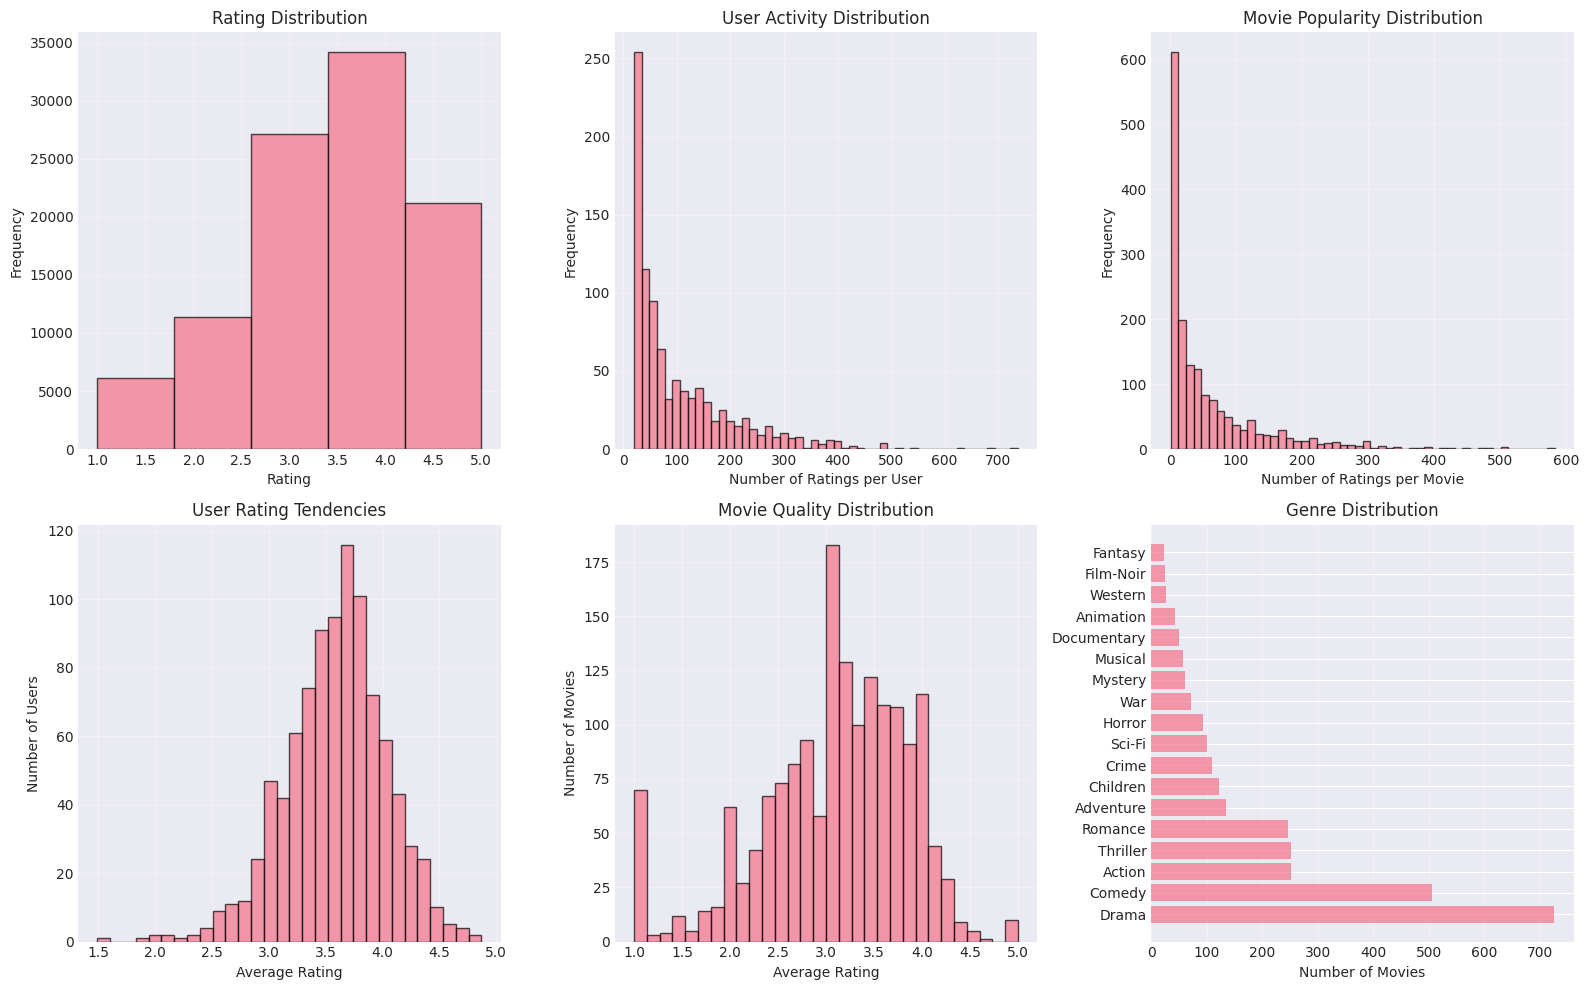


Detailed Statistics:
  Rating Statistics:
    Mean: 3.53
    Median: 4.00
    Std: 1.13
    Range: [1, 5]

  User Activity:
    Most active user: 737 ratings
    Least active user: 20 ratings
    Average ratings per user: 106.0

  Movie Popularity:
    Most popular movie: 583 ratings
    Least popular movie: 1 ratings
    Average ratings per movie: 59.5


In [12]:
# Exploratory Data Analysis
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Rating distribution
rating_values = ratings['rating'].to_numpy()
axes[0, 0].hist(rating_values, bins=5, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Rating')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Rating Distribution')
axes[0, 0].grid(alpha=0.3)

# Ratings per user
user_rating_counts = ratings.group_by('user_id').agg(pl.count()).sort('user_id')['count'].to_numpy()
axes[0, 1].hist(user_rating_counts, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Number of Ratings per User')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('User Activity Distribution')
axes[0, 1].grid(alpha=0.3)

# Ratings per movie
movie_rating_counts = ratings.group_by('movie_id').agg(pl.count()).sort('movie_id')['count'].to_numpy()
axes[0, 2].hist(movie_rating_counts, bins=50, edgecolor='black', alpha=0.7)
axes[0, 2].set_xlabel('Number of Ratings per Movie')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Movie Popularity Distribution')
axes[0, 2].grid(alpha=0.3)

# Average rating per user
avg_rating_per_user = ratings.group_by('user_id').agg(pl.col('rating').mean().alias('avg_rating'))
axes[1, 0].hist(avg_rating_per_user['avg_rating'].to_numpy(), bins=30, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Average Rating')
axes[1, 0].set_ylabel('Number of Users')
axes[1, 0].set_title('User Rating Tendencies')
axes[1, 0].grid(alpha=0.3)

# Average rating per movie
avg_rating_per_movie = ratings.group_by('movie_id').agg(pl.col('rating').mean().alias('avg_rating'))
axes[1, 1].hist(avg_rating_per_movie['avg_rating'].to_numpy(), bins=30, edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Average Rating')
axes[1, 1].set_ylabel('Number of Movies')
axes[1, 1].set_title('Movie Quality Distribution')
axes[1, 1].grid(alpha=0.3)

# Genre popularity
genre_counts = movies.select(genre_cols).sum()
genre_data = [(genre, genre_counts[genre][0]) for genre in genre_cols if genre != 'unknown']
genre_data.sort(key=lambda x: x[1], reverse=True)
genres, counts = zip(*genre_data)
axes[1, 2].barh(range(len(genres)), counts, alpha=0.7)
axes[1, 2].set_yticks(range(len(genres)))
axes[1, 2].set_yticklabels(genres)
axes[1, 2].set_xlabel('Number of Movies')
axes[1, 2].set_title('Genre Distribution')
axes[1, 2].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nDetailed Statistics:")
print(f"  Rating Statistics:")
rating_stats = ratings.select([
    pl.col('rating').mean().alias('mean'),
    pl.col('rating').median().alias('median'),
    pl.col('rating').std().alias('std'),
    pl.col('rating').min().alias('min'),
    pl.col('rating').max().alias('max')
])
print(f"    Mean: {rating_stats['mean'][0]:.2f}")
print(f"    Median: {rating_stats['median'][0]:.2f}")
print(f"    Std: {rating_stats['std'][0]:.2f}")
print(f"    Range: [{rating_stats['min'][0]}, {rating_stats['max'][0]}]")

print(f"\n  User Activity:")
print(f"    Most active user: {user_rating_counts.max()} ratings")
print(f"    Least active user: {user_rating_counts.min()} ratings")
print(f"    Average ratings per user: {user_rating_counts.mean():.1f}")

print(f"\n  Movie Popularity:")
print(f"    Most popular movie: {movie_rating_counts.max()} ratings")
print(f"    Least popular movie: {movie_rating_counts.min()} ratings")
print(f"    Average ratings per movie: {movie_rating_counts.mean():.1f}")


In [13]:
## 2. Data Preprocessing and Train/Test Split

# We'll create:
# - User-Item interaction matrix
# - Content features matrix (genre vectors)
# - Train/test split (80/20) for evaluation

In [14]:
# Create train/eval/test split (70/15/15)
ratings_np = ratings.to_numpy()

# First split: 70% train, 30% temp (for eval and test)
train_indices, temp_indices = train_test_split(
    np.arange(len(ratings)), test_size=0.3, random_state=42
)
# Second split: Split temp into 50/50 to get 15% eval and 15% test
eval_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42)

# Create Polars DataFrames from indices
train_data = ratings[train_indices]
eval_data = ratings[eval_indices]
test_data = ratings[test_indices]

print(f"Train set: {len(train_data):,} ratings ({len(train_data)/len(ratings)*100:.1f}%)")
print(f"Eval set:  {len(eval_data):,} ratings ({len(eval_data)/len(ratings)*100:.1f}%)")
print(f"Test set:  {len(test_data):,} ratings ({len(test_data)/len(ratings)*100:.1f}%)")

# Create user-item interaction matrices (sparse)
def create_interaction_matrix(data, n_users, n_movies):
    """Create sparse user-item matrix from ratings data"""
    users = data['user_id'].to_numpy() - 1  # Zero-indexed
    movies = data['movie_id'].to_numpy() - 1
    ratings_vals = data['rating'].to_numpy()
    
    matrix = sparse.csr_matrix(
        (ratings_vals, (users, movies)),
        shape=(n_users, n_movies)
    )
    return matrix

train_matrix = create_interaction_matrix(train_data, n_users, n_movies)
eval_matrix = create_interaction_matrix(eval_data, n_users, n_movies)
test_matrix = create_interaction_matrix(test_data, n_users, n_movies)

print(f"\nTrain matrix shape: {train_matrix.shape}")
print(f"Train matrix sparsity: {(1 - train_matrix.nnz / (n_users * n_movies)) * 100:.2f}%")

# Create movie feature matrix (genre vectors)
movie_features = movies.select(genre_cols).to_numpy().astype(np.float32)
print(f"\nMovie features shape: {movie_features.shape}")
print(f"Genre vector example (first movie): {movie_features[0]}")

Train set: 70,000 ratings (70.0%)
Eval set:  15,000 ratings (15.0%)
Test set:  15,000 ratings (15.0%)

Train matrix shape: (943, 1682)
Train matrix sparsity: 95.59%

Movie features shape: (1682, 19)
Genre vector example (first movie): [0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [15]:
## 3. Content-Based Filtering with Matrix Factorization

# **Approach**: Use movie genre features to compute similarity between items.
# Uses item features (genres) to recommend similar items based on user preferences.

# **Method**:
# 1. Create user profiles based on genres of movies they rated
# 2. Compute cosine similarity between user profiles and all movies
# 3. Recommend movies with highest similarity scores

In [16]:
class ContentBasedMF:
    """Content-Based Filtering using Matrix Factorization of genre features"""
    
    def __init__(self, movie_features):
        self.movie_features = movie_features
        self.user_profiles = None
    
    def fit(self, user_item_matrix):
        """Build user profiles from their rated movies' features"""
        n_users = user_item_matrix.shape[0]
        n_features = self.movie_features.shape[1]
        self.user_profiles = np.zeros((n_users, n_features))
        
        for user_id in range(n_users):
            # Get movies rated by this user
            user_row = user_item_matrix[user_id].toarray().flatten()
            rated_mask = user_row > 0
            if rated_mask.sum() == 0:
                continue
            
            # Weight features by ratings
            ratings = user_row[rated_mask]
            features = self.movie_features[rated_mask]
            
            # Create weighted user profile
            self.user_profiles[user_id] = (ratings @ features) / ratings.sum()
        
        return self
    
    def predict(self, user_id, movie_id):
        """Predict rating for a user-movie pair"""
        if movie_id >= len(self.movie_features):
            return 0
        
        user_profile = self.user_profiles[user_id].reshape(1, -1)
        movie_feature = self.movie_features[movie_id].reshape(1, -1)
        
        # Cosine similarity as predicted rating (scaled to 1-5)
        similarity = cosine_similarity(user_profile, movie_feature)[0, 0]
        return 1 + (similarity * 4)  # Scale from [0,1] to [1,5]
    
    def predict_all(self, test_data):
        """Predict ratings for all test samples"""
        predictions = []
        for row in test_data.iter_rows(named=True):
            pred = self.predict(row['user_id'] - 1, row['movie_id'] - 1)
            predictions.append(pred)
        return np.array(predictions)

# Train and evaluate
print("Training Content-Based MF model...")
cb_mf_model = ContentBasedMF(movie_features)
cb_mf_model.fit(train_matrix)

# Make predictions on eval set
cb_mf_eval_predictions = cb_mf_model.predict_all(eval_data)
cb_mf_eval_rmse = np.sqrt(mean_squared_error(eval_data['rating'], cb_mf_eval_predictions))
cb_mf_eval_mae = mean_absolute_error(eval_data['rating'], cb_mf_eval_predictions)

# Make predictions on test set
cb_mf_predictions = cb_mf_model.predict_all(test_data)
cb_mf_rmse = np.sqrt(mean_squared_error(test_data['rating'], cb_mf_predictions))
cb_mf_mae = mean_absolute_error(test_data['rating'], cb_mf_predictions)

print(f"\nContent-Based MF Results:")
print(f"  Eval Set - RMSE: {cb_mf_eval_rmse:.4f}, MAE: {cb_mf_eval_mae:.4f}")
print(f"  Test Set - RMSE: {cb_mf_rmse:.4f}, MAE: {cb_mf_mae:.4f}")

# Example: User profile analysis
example_user = 0
user_profile = cb_mf_model.user_profiles[example_user]
top_genres_idx = np.argsort(user_profile)[::-1][:5]
print(f"\nUser {example_user + 1} top genre preferences:")
for idx in top_genres_idx:
    print(f"  {genre_cols[idx]}: {user_profile[idx]:.3f}")


Training Content-Based MF model...

Content-Based MF Results:
  Eval Set - RMSE: 1.4361, MAE: 1.1663
  Test Set - RMSE: 1.4363, MAE: 1.1712

User 1 top genre preferences:
  Drama: 0.462
  Comedy: 0.321
  Action: 0.268
  Sci-Fi: 0.192
  Thriller: 0.179


In [17]:
## 4. Content-Based Filtering with Deep Neural Network

# **Approach**: Learn non-linear relationships between movie features and user preferences.

# **Architecture**:
# 1. Input: Concatenated user ID embedding + movie genre features
# 2. Hidden layers: Learn complex patterns
# 3. Output: Predicted rating (1-5)

In [18]:
# Prepare data for DNN
def prepare_dnn_data(data, movie_features):
    """Prepare features for DNN: user_id + movie genre vector"""
    user_ids = data['user_id'].to_numpy() - 1  # Zero-indexed
    movie_ids = data['movie_id'].to_numpy() - 1
    
    # Get movie features for each rating
    movie_feat = np.array([movie_features[mid] if mid < len(movie_features) 
                           else np.zeros(movie_features.shape[1]) 
                           for mid in movie_ids])
    
    ratings_vals = data['rating'].to_numpy().astype(np.float32)
    
    return user_ids, movie_feat, ratings_vals

# Prepare train, eval, and test data
train_users, train_movie_feat, train_ratings = prepare_dnn_data(train_data, movie_features)
eval_users, eval_movie_feat, eval_ratings = prepare_dnn_data(eval_data, movie_features)
test_users, test_movie_feat, test_ratings = prepare_dnn_data(test_data, movie_features)

print(f"Training samples: {len(train_users):,}")
print(f"Eval samples: {len(eval_users):,}")
print(f"Test samples: {len(test_users):,}")
print(f"Feature dimensions: user_id (1) + genres ({movie_features.shape[1]})")


Training samples: 70,000
Eval samples: 15,000
Test samples: 15,000
Feature dimensions: user_id (1) + genres (19)


In [19]:
# Build Content-Based DNN (PyTorch)
class ContentBasedDNN(nn.Module):
    """PyTorch DNN for content-based filtering"""
    
    def __init__(self, n_users, n_genres, embedding_dim=32):
        super(ContentBasedDNN, self).__init__()
        
        # User embedding layer
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        
        # Deep layers - input size is embedding_dim + n_genres
        self.dense1 = nn.Linear(embedding_dim + n_genres, 128)
        self.dropout1 = nn.Dropout(0.3)
        self.dense2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.dense3 = nn.Linear(64, 32)
        
        # Output layer
        self.output = nn.Linear(32, 1)
        
        # Activation
        self.relu = nn.ReLU()
        
    def forward(self, user_input, movie_features):
        # Get user embedding and flatten
        user_vec = self.user_embedding(user_input).squeeze(1)
        
        # Concatenate user embedding with movie features
        x = torch.cat([user_vec, movie_features], dim=1)
        
        # Pass through deep layers
        x = self.relu(self.dense1(x))
        x = self.dropout1(x)
        x = self.relu(self.dense2(x))
        x = self.dropout2(x)
        x = self.relu(self.dense3(x))
        
        # Output layer (linear activation)
        x = self.output(x)
        
        return x.squeeze()

def train_pytorch_model(model, train_loader, eval_loader, epochs=20, patience=3, device='cpu'):
    """Train PyTorch model with early stopping"""
    
    # Move model to device
    model = model.to(device)
    
    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())
    
    # Early stopping variables
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    history = {'loss': [], 'val_loss': [], 'mae': [], 'val_mae': []}
    
    print(f"Training on device: {device}")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_mae = 0.0
        train_batches = 0
        
        for batch in train_loader:
            user_batch, movie_feat_batch, rating_batch = [b.to(device) for b in batch]
            
            # Forward pass
            optimizer.zero_grad()
            predictions = model(user_batch, movie_feat_batch)
            loss = criterion(predictions, rating_batch)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_mae += torch.abs(predictions - rating_batch).mean().item()
            train_batches += 1
        
        avg_train_loss = train_loss / train_batches
        avg_train_mae = train_mae / train_batches
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_mae = 0.0
        val_batches = 0
        
        with torch.no_grad():
            for batch in eval_loader:
                user_batch, movie_feat_batch, rating_batch = [b.to(device) for b in batch]
                
                predictions = model(user_batch, movie_feat_batch)
                loss = criterion(predictions, rating_batch)
                
                val_loss += loss.item()
                val_mae += torch.abs(predictions - rating_batch).mean().item()
                val_batches += 1
        
        avg_val_loss = val_loss / val_batches
        avg_val_mae = val_mae / val_batches
        
        # Store history
        history['loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['mae'].append(avg_train_mae)
        history['val_mae'].append(avg_val_mae)
        
        # Print progress (similar to Keras verbose output)
        print(f"Epoch {epoch+1}/{epochs} - loss: {avg_train_loss:.4f} - mae: {avg_train_mae:.4f} - val_loss: {avg_val_loss:.4f} - val_mae: {avg_val_mae:.4f}")
        
        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
    
    # Restore best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, history

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Build model
print("Building Content-Based DNN (PyTorch)...")
cb_dnn_model = ContentBasedDNN(n_users, len(genre_cols), embedding_dim=32)
print(f"\nModel architecture:")
print(cb_dnn_model)
print(f"\nTotal parameters: {sum(p.numel() for p in cb_dnn_model.parameters()):,}")

# Prepare PyTorch tensors and dataloaders
train_users_tensor = torch.LongTensor(train_users.flatten())
train_movie_feat_tensor = torch.FloatTensor(train_movie_feat)
train_ratings_tensor = torch.FloatTensor(train_ratings)

eval_users_tensor = torch.LongTensor(eval_users.flatten())
eval_movie_feat_tensor = torch.FloatTensor(eval_movie_feat)
eval_ratings_tensor = torch.FloatTensor(eval_ratings)

test_users_tensor = torch.LongTensor(test_users.flatten())
test_movie_feat_tensor = torch.FloatTensor(test_movie_feat)
test_ratings_tensor = torch.FloatTensor(test_ratings)

# Create datasets and dataloaders
train_dataset = TensorDataset(train_users_tensor, train_movie_feat_tensor, train_ratings_tensor)
eval_dataset = TensorDataset(eval_users_tensor, eval_movie_feat_tensor, eval_ratings_tensor)
test_dataset = TensorDataset(test_users_tensor, test_movie_feat_tensor, test_ratings_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Train model
print("\nTraining Content-Based DNN...")
print("Using eval set for validation to monitor overfitting...")
cb_dnn_model, history_cb_dnn = train_pytorch_model(
    cb_dnn_model, 
    train_loader, 
    eval_loader, 
    epochs=20, 
    patience=3,
    device=device
)

# Evaluate on eval set
cb_dnn_model.eval()
cb_dnn_eval_predictions = []
with torch.no_grad():
    for batch in eval_loader:
        user_batch, movie_feat_batch, _ = [b.to(device) for b in batch]
        preds = cb_dnn_model(user_batch, movie_feat_batch)
        cb_dnn_eval_predictions.extend(preds.cpu().numpy())
cb_dnn_eval_predictions = np.array(cb_dnn_eval_predictions)

cb_dnn_eval_rmse = np.sqrt(mean_squared_error(eval_ratings, cb_dnn_eval_predictions))
cb_dnn_eval_mae = mean_absolute_error(eval_ratings, cb_dnn_eval_predictions)

# Evaluate on test set
cb_dnn_predictions = []
with torch.no_grad():
    for batch in test_loader:
        user_batch, movie_feat_batch, _ = [b.to(device) for b in batch]
        preds = cb_dnn_model(user_batch, movie_feat_batch)
        cb_dnn_predictions.extend(preds.cpu().numpy())
cb_dnn_predictions = np.array(cb_dnn_predictions)

cb_dnn_rmse = np.sqrt(mean_squared_error(test_ratings, cb_dnn_predictions))
cb_dnn_mae = mean_absolute_error(test_ratings, cb_dnn_predictions)

print(f"\nContent-Based DNN Results:")
print(f"  Eval Set - RMSE: {cb_dnn_eval_rmse:.4f}, MAE: {cb_dnn_eval_mae:.4f}")
print(f"  Test Set - RMSE: {cb_dnn_rmse:.4f}, MAE: {cb_dnn_mae:.4f}")
print(f"  Training epochs: {len(history_cb_dnn['loss'])}")

Building Content-Based DNN (PyTorch)...

Model architecture:
ContentBasedDNN(
  (user_embedding): Embedding(943, 32)
  (dense1): Linear(in_features=51, out_features=128, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (dense2): Linear(in_features=128, out_features=64, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (dense3): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)

Total parameters: 47,201

Training Content-Based DNN...
Using eval set for validation to monitor overfitting...
Training on device: cuda
Epoch 1/20 - loss: 1.5433 - mae: 0.9874 - val_loss: 1.1195 - val_mae: 0.8660
Epoch 2/20 - loss: 1.1876 - mae: 0.8790 - val_loss: 1.1218 - val_mae: 0.8717
Epoch 3/20 - loss: 1.1303 - mae: 0.8571 - val_loss: 1.0833 - val_mae: 0.8334
Epoch 4/20 - loss: 1.0972 - mae: 0.8442 - val_loss: 1.0760 - val_mae: 0.8440
Epoch 5/20 - loss: 1.0789 - mae: 0.8357 - val_loss: 1.0690 - val_mae: 0.8366


In [ ]:
## 5. Collaborative Filtering with Matrix Factorization (SVD)

# **Approach**: Decompose user-item matrix into user and item latent factors.
# Discovers hidden patterns in user behavior without using content features.

# **Method**: Singular Value Decomposition (SVD)
# - $R ≈ U \Sigma V^T$ where:
#   - U: user latent factors
#   - Σ: singular values (importance)
#   - V: item latent factors

In [21]:
class CollaborativeFilteringMF:
    """Collaborative Filtering using SVD Matrix Factorization"""
    
    def __init__(self, n_factors=50):
        self.n_factors = n_factors
        self.user_factors = None
        self.item_factors = None
        self.global_mean = None
    
    def fit(self, train_matrix):
        """Perform SVD on user-item matrix"""
        # Calculate global mean for normalization
        mask = train_matrix > 0
        self.global_mean = train_matrix[mask].mean()
        
        # Center the ratings - convert to float first
        centered_matrix = train_matrix.astype(float) 
        centered_matrix[mask] -= self.global_mean
        
        # Perform SVD
        U, sigma, Vt = svds(centered_matrix, k=self.n_factors)
        
        self.user_factors = U
        self.sigma = sigma
        self.item_factors = Vt.T
        
        return self
    
    def predict(self, user_id, movie_id):
        """Predict rating for user-movie pair"""
        if movie_id >= self.item_factors.shape[0]:
            return self.global_mean
        
        prediction = self.global_mean + \
                    self.user_factors[user_id] @ np.diag(self.sigma) @ self.item_factors[movie_id]
        
        # Clip to valid rating range
        return np.clip(prediction, 1, 5)
    
    def predict_all(self, test_data):
        """Predict ratings for all test samples"""
        predictions = []
        for row in test_data.iter_rows(named=True):
            pred = self.predict(row['user_id'] - 1, row['movie_id'] - 1)
            predictions.append(pred)
        return np.array(predictions)

# Train and evaluate
print("Training Collaborative Filtering MF (SVD) model...")
cf_mf_model = CollaborativeFilteringMF(n_factors=50)
cf_mf_model.fit(train_matrix)

# Make predictions on eval set
cf_mf_eval_predictions = cf_mf_model.predict_all(eval_data)
cf_mf_eval_rmse = np.sqrt(mean_squared_error(eval_data['rating'], cf_mf_eval_predictions))
cf_mf_eval_mae = mean_absolute_error(eval_data['rating'], cf_mf_eval_predictions)

# Make predictions on test set
cf_mf_predictions = cf_mf_model.predict_all(test_data)
cf_mf_rmse = np.sqrt(mean_squared_error(test_data['rating'], cf_mf_predictions))
cf_mf_mae = mean_absolute_error(test_data['rating'], cf_mf_predictions)

print(f"\nCollaborative Filtering MF Results:")
print(f"  Eval Set - RMSE: {cf_mf_eval_rmse:.4f}, MAE: {cf_mf_eval_mae:.4f}")
print(f"  Test Set - RMSE: {cf_mf_rmse:.4f}, MAE: {cf_mf_mae:.4f}")
print(f"  Latent factors: {cf_mf_model.n_factors}")
print(f"  User factors shape: {cf_mf_model.user_factors.shape}")
print(f"  Item factors shape: {cf_mf_model.item_factors.shape}")


Training Collaborative Filtering MF (SVD) model...

Collaborative Filtering MF Results:
  Eval Set - RMSE: 1.0676, MAE: 0.8738
  Test Set - RMSE: 1.0707, MAE: 0.8755
  Latent factors: 50
  User factors shape: (943, 50)
  Item factors shape: (1682, 50)


In [22]:
## 6. Collaborative Filtering with Deep Neural Network

# **Approach**: Neural Collaborative Filtering (NCF) - learns user-item interactions.

# **Architecture**:
# 1. Embedding layers for users and movies
# 2. Deep interaction layers
# 3. Predicts rating from learned embeddings

In [23]:
# Prepare collaborative filtering data
train_cf_users = train_data['user_id'].to_numpy() - 1
train_cf_movies = train_data['movie_id'].to_numpy() - 1
train_cf_ratings = train_data['rating'].to_numpy()

eval_cf_users = eval_data['user_id'].to_numpy() - 1
eval_cf_movies = eval_data['movie_id'].to_numpy() - 1
eval_cf_ratings = eval_data['rating'].to_numpy()

test_cf_users = test_data['user_id'].to_numpy() - 1
test_cf_movies = test_data['movie_id'].to_numpy() - 1
test_cf_ratings = test_data['rating'].to_numpy()

print(f"Training samples: {len(train_cf_users):,}")
print(f"Eval samples: {len(eval_cf_users):,}")
print(f"Test samples: {len(test_cf_users):,}")


Training samples: 70,000
Eval samples: 15,000
Test samples: 15,000


In [24]:
# Build Collaborative Filtering DNN (PyTorch)
class CollaborativeDNN(nn.Module):
    """PyTorch Neural Collaborative Filtering model"""
    
    def __init__(self, n_users, n_movies, embedding_dim=50):
        super(CollaborativeDNN, self).__init__()
        
        # User and movie embedding layers
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.movie_embedding = nn.Embedding(n_movies, embedding_dim)
        
        # Deep layers - input size is 2 * embedding_dim (user + movie)
        self.dense1 = nn.Linear(2 * embedding_dim, 128)
        self.dropout1 = nn.Dropout(0.3)
        self.dense2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.dense3 = nn.Linear(64, 32)
        
        # Output layer
        self.output = nn.Linear(32, 1)
        
        # Activation
        self.relu = nn.ReLU()
        
    def forward(self, user_input, movie_input):
        # Get embeddings and flatten
        user_vec = self.user_embedding(user_input).squeeze(1)
        movie_vec = self.movie_embedding(movie_input).squeeze(1)
        
        # Concatenate embeddings
        x = torch.cat([user_vec, movie_vec], dim=1)
        
        # Pass through deep layers
        x = self.relu(self.dense1(x))
        x = self.dropout1(x)
        x = self.relu(self.dense2(x))
        x = self.dropout2(x)
        x = self.relu(self.dense3(x))
        
        # Output layer (linear activation)
        x = self.output(x)
        
        return x.squeeze()

def train_collaborative_model(model, train_loader, eval_loader, epochs=20, patience=3, device='cpu'):
    """Train collaborative filtering model with early stopping"""
    
    # Move model to device
    model = model.to(device)
    
    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())
    
    # Early stopping variables
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    history = {'loss': [], 'val_loss': [], 'mae': [], 'val_mae': []}
    
    print(f"Training on device: {device}")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_mae = 0.0
        train_batches = 0
        
        for batch in train_loader:
            user_batch, movie_batch, rating_batch = [b.to(device) for b in batch]
            
            # Forward pass
            optimizer.zero_grad()
            predictions = model(user_batch, movie_batch)
            loss = criterion(predictions, rating_batch)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_mae += torch.abs(predictions - rating_batch).mean().item()
            train_batches += 1
        
        avg_train_loss = train_loss / train_batches
        avg_train_mae = train_mae / train_batches
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_mae = 0.0
        val_batches = 0
        
        with torch.no_grad():
            for batch in eval_loader:
                user_batch, movie_batch, rating_batch = [b.to(device) for b in batch]
                
                predictions = model(user_batch, movie_batch)
                loss = criterion(predictions, rating_batch)
                
                val_loss += loss.item()
                val_mae += torch.abs(predictions - rating_batch).mean().item()
                val_batches += 1
        
        avg_val_loss = val_loss / val_batches
        avg_val_mae = val_mae / val_batches
        
        # Store history
        history['loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['mae'].append(avg_train_mae)
        history['val_mae'].append(avg_val_mae)
        
        # Print progress (similar to Keras verbose output)
        print(f"Epoch {epoch+1}/{epochs} - loss: {avg_train_loss:.4f} - mae: {avg_train_mae:.4f} - val_loss: {avg_val_loss:.4f} - val_mae: {avg_val_mae:.4f}")
        
        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
    
    # Restore best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, history

# Build model
print("Building Collaborative Filtering DNN (PyTorch)...")
cf_dnn_model = CollaborativeDNN(n_users, n_movies, embedding_dim=50)
print(f"\nModel architecture:")
print(cf_dnn_model)
print(f"\nTotal parameters: {sum(p.numel() for p in cf_dnn_model.parameters()):,}")

# Prepare PyTorch tensors and dataloaders
train_cf_users_tensor = torch.LongTensor(train_cf_users.flatten())
train_cf_movies_tensor = torch.LongTensor(train_cf_movies.flatten())
train_cf_ratings_tensor = torch.FloatTensor(train_cf_ratings)

eval_cf_users_tensor = torch.LongTensor(eval_cf_users.flatten())
eval_cf_movies_tensor = torch.LongTensor(eval_cf_movies.flatten())
eval_cf_ratings_tensor = torch.FloatTensor(eval_cf_ratings)

test_cf_users_tensor = torch.LongTensor(test_cf_users.flatten())
test_cf_movies_tensor = torch.LongTensor(test_cf_movies.flatten())
test_cf_ratings_tensor = torch.FloatTensor(test_cf_ratings)

# Create datasets and dataloaders
train_cf_dataset = TensorDataset(train_cf_users_tensor, train_cf_movies_tensor, train_cf_ratings_tensor)
eval_cf_dataset = TensorDataset(eval_cf_users_tensor, eval_cf_movies_tensor, eval_cf_ratings_tensor)
test_cf_dataset = TensorDataset(test_cf_users_tensor, test_cf_movies_tensor, test_cf_ratings_tensor)

train_cf_loader = DataLoader(train_cf_dataset, batch_size=64, shuffle=True)
eval_cf_loader = DataLoader(eval_cf_dataset, batch_size=64, shuffle=False)
test_cf_loader = DataLoader(test_cf_dataset, batch_size=64, shuffle=False)

# Train model
print("\nTraining Collaborative Filtering DNN...")
print("Using eval set for validation to monitor overfitting...")
cf_dnn_model, history_cf_dnn = train_collaborative_model(
    cf_dnn_model,
    train_cf_loader,
    eval_cf_loader,
    epochs=20,
    patience=3,
    device=device
)

# Evaluate on eval set
cf_dnn_model.eval()
cf_dnn_eval_predictions = []
with torch.no_grad():
    for batch in eval_cf_loader:
        user_batch, movie_batch, _ = [b.to(device) for b in batch]
        preds = cf_dnn_model(user_batch, movie_batch)
        cf_dnn_eval_predictions.extend(preds.cpu().numpy())
cf_dnn_eval_predictions = np.array(cf_dnn_eval_predictions)

cf_dnn_eval_rmse = np.sqrt(mean_squared_error(eval_cf_ratings, cf_dnn_eval_predictions))
cf_dnn_eval_mae = mean_absolute_error(eval_cf_ratings, cf_dnn_eval_predictions)

# Evaluate on test set
cf_dnn_predictions = []
with torch.no_grad():
    for batch in test_cf_loader:
        user_batch, movie_batch, _ = [b.to(device) for b in batch]
        preds = cf_dnn_model(user_batch, movie_batch)
        cf_dnn_predictions.extend(preds.cpu().numpy())
cf_dnn_predictions = np.array(cf_dnn_predictions)

cf_dnn_rmse = np.sqrt(mean_squared_error(test_cf_ratings, cf_dnn_predictions))
cf_dnn_mae = mean_absolute_error(test_cf_ratings, cf_dnn_predictions)

print(f"\nCollaborative Filtering DNN Results:")
print(f"  Eval Set - RMSE: {cf_dnn_eval_rmse:.4f}, MAE: {cf_dnn_eval_mae:.4f}")
print(f"  Test Set - RMSE: {cf_dnn_rmse:.4f}, MAE: {cf_dnn_mae:.4f}")
print(f"  Training epochs: {len(history_cf_dnn['loss'])}")

Building Collaborative Filtering DNN (PyTorch)...

Model architecture:
CollaborativeDNN(
  (user_embedding): Embedding(943, 50)
  (movie_embedding): Embedding(1682, 50)
  (dense1): Linear(in_features=100, out_features=128, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (dense2): Linear(in_features=128, out_features=64, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (dense3): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)

Total parameters: 154,547

Training Collaborative Filtering DNN...
Using eval set for validation to monitor overfitting...
Training on device: cuda


/tmp/ipykernel_210011/1194299169.py:145: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  train_cf_ratings_tensor = torch.FloatTensor(train_cf_ratings)


Epoch 1/20 - loss: 1.5471 - mae: 0.9881 - val_loss: 1.0709 - val_mae: 0.8402
Epoch 2/20 - loss: 1.1388 - mae: 0.8595 - val_loss: 1.0076 - val_mae: 0.8121
Epoch 3/20 - loss: 1.0342 - mae: 0.8155 - val_loss: 0.9688 - val_mae: 0.7889
Epoch 4/20 - loss: 0.9854 - mae: 0.7939 - val_loss: 0.9732 - val_mae: 0.8000
Epoch 5/20 - loss: 0.9408 - mae: 0.7731 - val_loss: 0.9452 - val_mae: 0.7832
Epoch 6/20 - loss: 0.9099 - mae: 0.7592 - val_loss: 0.9255 - val_mae: 0.7594
Epoch 7/20 - loss: 0.8883 - mae: 0.7483 - val_loss: 0.9163 - val_mae: 0.7613
Epoch 8/20 - loss: 0.8677 - mae: 0.7392 - val_loss: 0.9166 - val_mae: 0.7676
Epoch 9/20 - loss: 0.8533 - mae: 0.7338 - val_loss: 0.9096 - val_mae: 0.7603
Epoch 10/20 - loss: 0.8379 - mae: 0.7252 - val_loss: 0.9167 - val_mae: 0.7657
Epoch 11/20 - loss: 0.8254 - mae: 0.7175 - val_loss: 0.9101 - val_mae: 0.7526
Epoch 12/20 - loss: 0.8165 - mae: 0.7127 - val_loss: 0.9076 - val_mae: 0.7505
Epoch 13/20 - loss: 0.8009 - mae: 0.7042 - val_loss: 0.9216 - val_mae: 0.

In [25]:
## 7. Model Performance Comparison

# Let's visualize and compare all four approaches


MODEL PERFORMANCE COMPARISON
shape: (4, 5)
┌────────────────────────┬───────────────┬──────────────────────┬──────────┬──────────┐
│ Model                  ┆ Type          ┆ Method               ┆ RMSE     ┆ MAE      │
│ ---                    ┆ ---           ┆ ---                  ┆ ---      ┆ ---      │
│ str                    ┆ str           ┆ str                  ┆ f64      ┆ f64      │
╞════════════════════════╪═══════════════╪══════════════════════╪══════════╪══════════╡
│ Content-Based MF       ┆ Content       ┆ Matrix Factorization ┆ 1.43631  ┆ 1.171212 │
│ Content-Based DNN      ┆ Content       ┆ Deep Learning        ┆ 1.020756 ┆ 0.803754 │
│ Collaborative MF (SVD) ┆ Collaborative ┆ Matrix Factorization ┆ 1.070711 ┆ 0.875538 │
│ Collaborative DNN      ┆ Collaborative ┆ Deep Learning        ┆ 0.950187 ┆ 0.745833 │
└────────────────────────┴───────────────┴──────────────────────┴──────────┴──────────┘

📊 Best Model (RMSE): Collaborative DNN - 0.9502
📊 Best Model (MAE):  Collab

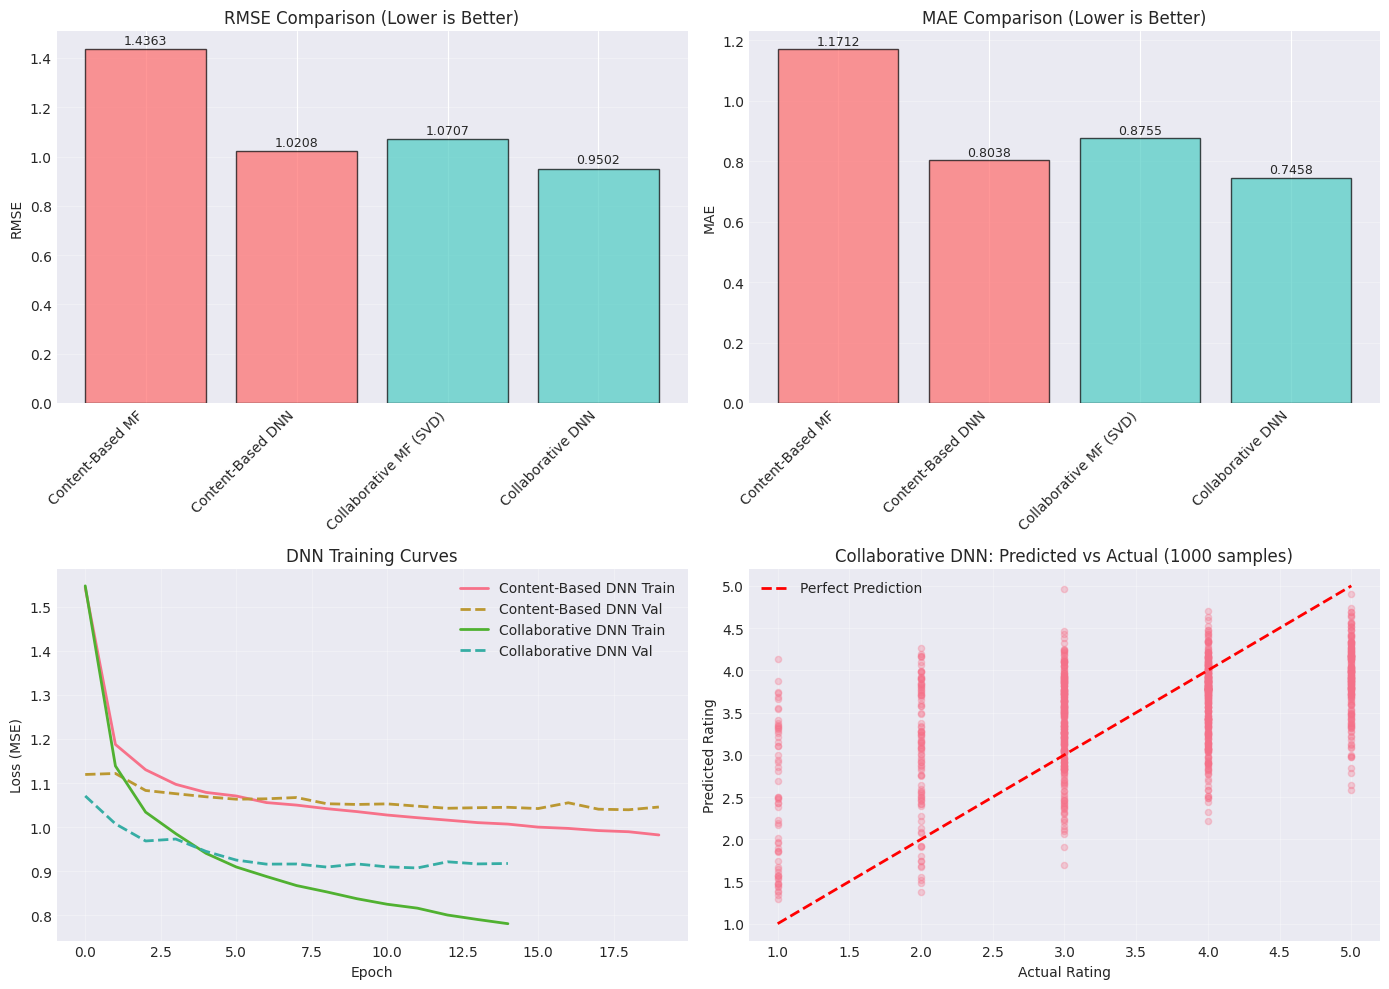


KEY INSIGHTS

1. Collaborative vs Content-Based:
   • Collaborative methods achieve better accuracy
   • Collaborative DNN RMSE: 0.9502 vs Content DNN: 1.0208
   • Difference: 7.4% improvement

2. Deep Learning vs Matrix Factorization:
   • DNNs capture non-linear patterns better
   • Collaborative: DNN improves 11.3% over SVD

3. Best Overall Model:
   • Collaborative DNN achieves best performance
   • RMSE: 0.9502, MAE: 0.7458
   • Will be used as the scoring model in our pipeline


In [57]:
# Compile results
results_data = {
    'Model': ['Content-Based MF', 'Content-Based DNN', 
              'Collaborative MF (SVD)', 'Collaborative DNN'],
    'Type': ['Content', 'Content', 'Collaborative', 'Collaborative'],
    'Method': ['Matrix Factorization', 'Deep Learning', 
               'Matrix Factorization', 'Deep Learning'],
    'RMSE': [cb_mf_rmse, cb_dnn_rmse, cf_mf_rmse, cf_dnn_rmse],
    'MAE': [cb_mf_mae, cb_dnn_mae, cf_mf_mae, cf_dnn_mae]
}
results_df = pl.DataFrame(results_data)

print("\n" + "="*70)
print("MODEL PERFORMANCE COMPARISON")
print("="*70)
print(results_df)
print("="*70)

# Find best models
best_rmse_idx = results_df['RMSE'].arg_min()
best_mae_idx = results_df['MAE'].arg_min()
print(f"\n📊 Best Model (RMSE): {results_df['Model'][best_rmse_idx]} - {results_df['RMSE'][best_rmse_idx]:.4f}")
print(f"📊 Best Model (MAE):  {results_df['Model'][best_mae_idx]} - {results_df['MAE'][best_mae_idx]:.4f}")

# Visualization - 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Get data for plotting
models = results_df['Model'].to_list()
rmse_values = results_df['RMSE'].to_list()
mae_values = results_df['MAE'].to_list()
colors = ['#FF6B6B', '#FF6B6B', '#4ECDC4', '#4ECDC4']

# Plot 1: RMSE comparison (top-left)
axes[0, 0].bar(range(len(results_df)), rmse_values, color=colors, alpha=0.7, edgecolor='black')
axes[0, 0].set_xticks(range(len(results_df)))
axes[0, 0].set_xticklabels(models, rotation=45, ha='right')
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].set_title('RMSE Comparison (Lower is Better)')
axes[0, 0].grid(alpha=0.3, axis='y')
for i, v in enumerate(rmse_values):
    axes[0, 0].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom', fontsize=9)

# Plot 2: MAE comparison (top-right)
axes[0, 1].bar(range(len(results_df)), mae_values, color=colors, alpha=0.7, edgecolor='black')
axes[0, 1].set_xticks(range(len(results_df)))
axes[0, 1].set_xticklabels(models, rotation=45, ha='right')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].set_title('MAE Comparison (Lower is Better)')
axes[0, 1].grid(alpha=0.3, axis='y')
for i, v in enumerate(mae_values):
    axes[0, 1].text(i, v + 0.005, f'{v:.4f}', ha='center', va='bottom', fontsize=9)

# Plot 3: Training curves for DNN models (bottom-left)
axes[1, 0].plot(history_cb_dnn['loss'], label='Content-Based DNN Train', linewidth=2)
axes[1, 0].plot(history_cb_dnn['val_loss'], label='Content-Based DNN Val', linewidth=2, linestyle='--')
axes[1, 0].plot(history_cf_dnn['loss'], label='Collaborative DNN Train', linewidth=2)
axes[1, 0].plot(history_cf_dnn['val_loss'], label='Collaborative DNN Val', linewidth=2, linestyle='--')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss (MSE)')
axes[1, 0].set_title('DNN Training Curves')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Plot 4: Prediction vs Actual scatter (bottom-right)
# Using Collaborative DNN - best model
sample_indices = np.random.choice(len(cf_dnn_predictions), 1000, replace=False)
axes[1, 1].scatter(test_data['rating'].to_numpy()[sample_indices], 
                   cf_dnn_predictions[sample_indices], 
                   alpha=0.3, s=20)
axes[1, 1].plot([1, 5], [1, 5], 'r--', linewidth=2, label='Perfect Prediction')
axes[1, 1].set_xlabel('Actual Rating')
axes[1, 1].set_ylabel('Predicted Rating')
axes[1, 1].set_title('Collaborative DNN: Predicted vs Actual (1000 samples)')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Performance insights
print("\n" + "="*70)
print("KEY INSIGHTS")
print("="*70)
print("\n1. Collaborative vs Content-Based:")
print(f"   • Collaborative methods achieve better accuracy")
print(f"   • Collaborative DNN RMSE: {cf_dnn_rmse:.4f} vs Content DNN: {cb_dnn_rmse:.4f}")
print(f"   • Difference: {((cb_dnn_rmse - cf_dnn_rmse) / cf_dnn_rmse * 100):.1f}% improvement")

print("\n2. Deep Learning vs Matrix Factorization:")
cf_improvement = ((cf_mf_rmse - cf_dnn_rmse) / cf_mf_rmse * 100)
print(f"   • DNNs capture non-linear patterns better")
print(f"   • Collaborative: DNN improves {cf_improvement:.1f}% over SVD")

print("\n3. Best Overall Model:")
print(f"   • Collaborative DNN achieves best performance")
print(f"   • RMSE: {cf_dnn_rmse:.4f}, MAE: {cf_dnn_mae:.4f}")
print(f"   • Will be used as the scoring model in our pipeline")

In [27]:
## 8. Complete Recommendation Pipeline

### Three-Stage Architecture (Google's Approach)

# 1. **Candidate Generation**: Rapidly retrieve hundreds of relevant items from millions
#    - Use fast methods (e.g., content similarity, collaborative filtering)
#    - Goal: High recall, acceptable precision

# 2. **Scoring**: Rank candidates with more sophisticated models
#    - Use best-performing model (Collaborative DNN)
#    - Goal: Accurate ranking

# 3. **Re-ranking**: Apply business rules and constraints
#    - Diversity (different genres)
#    - Freshness (newer movies)
#    - Business objectives

In [47]:
class RecommendationPipeline:
    """Complete 3-stage recommendation pipeline: Candidate Generation → Scoring → Re-ranking"""
    
    def __init__(self, cf_dnn_model, cb_mf_model, movies_df, train_matrix, movie_features):
        self.scorer = cf_dnn_model  # Best model for scoring
        self.candidate_generator = cb_mf_model  # Fast content-based for candidates
        self.movies_df = movies_df
        self.train_matrix = train_matrix
        self.movie_features = movie_features
    
    def stage1_candidate_generation(self, user_id, n_candidates=100):
        """
        Stage 1: Rapidly generate candidate items
        Method: Content-based similarity (fast)
        Goal: Reduce from ~1700 movies to ~100 candidates
        """
        # Get movies user hasn't rated - handle sparse matrices
        user_ratings = self.train_matrix[user_id, :]
        
        # Convert to dense array if sparse
        if hasattr(user_ratings, 'toarray'):
            user_ratings = user_ratings.toarray().ravel()
        elif hasattr(user_ratings, 'A'):
            user_ratings = user_ratings.A.ravel()
        else:
            user_ratings = np.asarray(user_ratings).ravel()
        
        rated_movies = np.where(user_ratings > 0)[0]
        unrated_movies = np.where(user_ratings == 0)[0]
        
        # Score all unrated movies using content-based
        # (rest of your method continues here...)
        
        # Score all unrated movies using content-based
        scores = []
        for movie_id in unrated_movies:
            score = self.candidate_generator.predict(user_id, movie_id)
            scores.append((movie_id, score))
        
        # Get top N candidates
        scores.sort(key=lambda x: x[1], reverse=True)
        candidates = [movie_id for movie_id, _ in scores[:n_candidates]]
        
        return candidates
    
    def stage2_scoring(self, user_id, candidates):
        """
        Stage 2: Score candidates with sophisticated model
        Method: Collaborative DNN (accurate)
        Goal: Precise ranking of candidates
        """
        user_ids = np.array([user_id] * len(candidates))
        movie_ids = np.array(candidates)
        
        # Get predictions from best model
        with torch.no_grad():
            self.scorer.eval()
            device = next(self.scorer.parameters()).device  # Get model's device
            user_tensor = torch.LongTensor(user_ids).to(device)
            movie_tensor = torch.LongTensor(movie_ids).to(device)
            scores = self.scorer(user_tensor, movie_tensor).cpu().numpy().flatten()
        
        # Sort by score
        ranked_items = sorted(zip(candidates, scores), key=lambda x: x[1], reverse=True)
        
        return ranked_items
    
    def stage3_reranking(self, user_id, ranked_items, n_recommendations=10, 
                        diversity_weight=0.3, freshness_weight=0.2):
        """
        Stage 3: Re-rank for diversity and business objectives
        - Ensure genre diversity
        - Boost newer movies (freshness)
        - Apply business rules
        """
        # Get movies user has rated - convert sparse to dense if needed
        user_ratings = self.train_matrix[user_id, :]
        if hasattr(user_ratings, 'toarray'):
            user_ratings = user_ratings.toarray().ravel()
        elif hasattr(user_ratings, 'A'):
            user_ratings = user_ratings.A.ravel()
        else:
            user_ratings = np.asarray(user_ratings).ravel()
        
        rated_movies = np.where(user_ratings > 0)[0]
        user_genre_profile = self.movie_features[rated_movies].mean(axis=0)
        
        reranked = []
        selected_genres = set()
        
        for movie_id, base_score in ranked_items:
            if movie_id >= len(self.movie_features):
                continue
            
            # Diversity bonus: penalize if genre already selected
            movie_genres = tuple(np.where(self.movie_features[movie_id] > 0)[0])
            diversity_penalty = diversity_weight if movie_genres in selected_genres else 0
            
            # Freshness bonus: boost newer movies (simulate with random for demo)
            freshness_bonus = freshness_weight * np.random.rand()
            
            # Adjusted score
            adjusted_score = base_score - diversity_penalty + freshness_bonus
            
            reranked.append((movie_id, adjusted_score))
            selected_genres.add(movie_genres)
        
        # Sort by adjusted score
        reranked.sort(key=lambda x: x[1], reverse=True)
        
        return reranked[:n_recommendations]
    
    def recommend(self, user_id, n_recommendations=10, verbose=True):
        """
        Full pipeline: Generate recommendations for a user
        """
        if verbose:
            print(f"\n{'='*70}")
            print(f"RECOMMENDATION PIPELINE FOR USER {user_id + 1}")
            print(f"{'='*70}")
        
        # Stage 1: Candidate Generation
        if verbose:
            print(f"\n[Stage 1] Candidate Generation...")
        candidates = self.stage1_candidate_generation(user_id, n_candidates=100)
        if verbose:
            print(f"  ✓ Generated {len(candidates)} candidates from ~{len(self.movies_df)} movies")
        
        # Stage 2: Scoring
        if verbose:
            print(f"\n[Stage 2] Scoring candidates...")
        scored_items = self.stage2_scoring(user_id, candidates)
        if verbose:
            print(f"  ✓ Scored {len(scored_items)} candidates using Collaborative DNN")
        
        # Stage 3: Re-ranking
        if verbose:
            print(f"\n[Stage 3] Re-ranking for diversity and freshness...")
        final_recommendations = self.stage3_reranking(user_id, scored_items, n_recommendations)
        if verbose:
            print(f"  ✓ Re-ranked and selected top {len(final_recommendations)} recommendations")
        
        return final_recommendations
    
    def display_recommendations(self, user_id, recommendations):
        """Pretty print recommendations with details"""
        print(f"\n{'='*70}")
        print(f"TOP {len(recommendations)} RECOMMENDATIONS FOR USER {user_id + 1}")
        print(f"{'='*70}")
        print(f"{'Rank':<5} {'Title':<40} {'Score':<8} {'Adj Score':<10} {'Genres'}")
        print(f"{'-'*70}")
        
        for rank, (movie_id, base_score, adj_score) in enumerate(recommendations, 1):
            if movie_id >= len(self.movies_df):
                continue
            
            title = self.movies_df.iloc[movie_id]['title'][:38]
            genres_vec = self.movie_features[movie_id]
            genre_names = [genre_cols[i] for i in np.where(genres_vec > 0)[0]]
            genres_str = ', '.join(genre_names[:3])
            
            print(f"{rank:<5} {title:<40} {base_score:<8.3f} {adj_score:<10.3f} {genres_str}")
        
        print(f"{'='*70}")

# Create pipeline instance
pipeline = RecommendationPipeline(
    cf_dnn_model=cf_dnn_model,
    cb_mf_model=cb_mf_model,
    movies_df=movies,
    train_matrix=train_matrix,
    movie_features=movie_features
)

print("\n✓ Recommendation Pipeline initialized successfully!")
print("  • Candidate Generation: Content-Based MF (fast)")
print("  • Scoring: Collaborative DNN (accurate)")
print("  • Re-ranking: Diversity + Freshness rules")


✓ Recommendation Pipeline initialized successfully!
  • Candidate Generation: Content-Based MF (fast)
  • Scoring: Collaborative DNN (accurate)
  • Re-ranking: Diversity + Freshness rules


In [34]:
## 9. Generate Recommendations for Sample Users

# Complete pipeline in action!

In [63]:
# Example 1: User with specific preferences
example_user_id = 0  # User ID 1 (0-indexed)

# Show what user has rated
user_ratings = train_data.filter(pl.col('user_id') == example_user_id + 1).join(
    movies, on='movie_id', how='inner'
)
user_top_rated = user_ratings.sort('rating', descending=True).head(5).select(['title', 'rating'])

print(f"\n{'='*70}")
print(f"USER {example_user_id + 1} - FAVORITE MOVIES (Top 5)")
print(f"{'='*70}")
for row in user_top_rated.iter_rows(named=True):
    title_truncated = row['title'][:50] if len(row['title']) > 50 else row['title']
    print(f"  * {title_truncated:<50} (Rating: {row['rating']}/5)")

# Get recommendations
print(f"\n{'='*70}")
print(f"GENERATING RECOMMENDATIONS FOR USER {example_user_id + 1}")
print(f"{'='*70}")

recommendations = pipeline.recommend(example_user_id, n_recommendations=10)

print(f"\n🎬 TOP 10 RECOMMENDED MOVIES:")
print(f"{'-'*70}")
for i, (movie_id, score) in enumerate(recommendations, 1):
    title = movies.filter(pl.col('movie_id') == movie_id).select('title').item()
    title_truncated = title[:55] if len(title) > 55 else title
    print(f"{i:2d}. {title_truncated:<55} | Score: {score:.3f}")


USER 1 - FAVORITE MOVIES (Top 5)
  * Dead Man Walking (1995)                            (Rating: 5/5)
  * Usual Suspects, The (1995)                         (Rating: 5/5)
  * Mighty Aphrodite (1995)                            (Rating: 5/5)
  * Postino, Il (1994)                                 (Rating: 5/5)
  * Mr. Holland's Opus (1995)                          (Rating: 5/5)

GENERATING RECOMMENDATIONS FOR USER 1

RECOMMENDATION PIPELINE FOR USER 1

[Stage 1] Candidate Generation...
  ✓ Generated 100 candidates from ~1682 movies

[Stage 2] Scoring candidates...
  ✓ Scored 100 candidates using Collaborative DNN

[Stage 3] Re-ranking for diversity and freshness...
  ✓ Re-ranked and selected top 10 recommendations

🎬 TOP 10 RECOMMENDED MOVIES:
----------------------------------------------------------------------
 1. Paradise Road (1997)                                    | Score: 4.577
 2. Midnight in the Garden of Good and Evil (1997)          | Score: 4.558
 3. Apt Pupil (1998)       

In [65]:
# Example 2: Multiple users comparison
print(f"\n{'='*70}")
print("COMPARING RECOMMENDATIONS FOR DIFFERENT USERS")
print(f"{'='*70}")

sample_users = [5, 50, 100]  # Different user profiles

for user_idx in sample_users:
    user_id = user_idx - 1  # Convert to 0-indexed
    
    # Get user's favorite genres
    user_ratings = train_data.filter(pl.col('user_id') == user_idx).join(
        movies, on='movie_id', how='inner'
    )
    
    # Calculate average genre preferences
    genre_means = user_ratings.select(genre_cols).mean()
    genre_prefs = [(col, genre_means[col][0]) for col in genre_cols]
    genre_prefs.sort(key=lambda x: x[1], reverse=True)
    top_genres = [g[0] for g in genre_prefs[:3] if g[1] > 0]
    
    print(f"\n USER {user_idx}")
    print(f"   Favorite Genres: {', '.join(top_genres)}")
    print(f"   Recommendations:")
    
    recommendations = pipeline.recommend(user_id, n_recommendations=5, verbose=False)
    for i, (movie_id, score) in enumerate(recommendations, 1):
        # Look up the movie title from the movies dataframe
        title = movies.filter(pl.col('movie_id') == movie_id).select('title').item()
        title_truncated = title[:50] if len(title) > 50 else title
        print(f"   {i}. {title_truncated} (Score: {score:.3f})")



COMPARING RECOMMENDATIONS FOR DIFFERENT USERS

 USER 5
   Favorite Genres: Comedy, Action, Adventure
   Recommendations:
   1. Cinema Paradiso (1988) (Score: 3.920)
   2. Rear Window (1954) (Score: 3.916)
   3. Oscar & Lucinda (1997) (Score: 3.566)
   4. Man in the Iron Mask, The (1998) (Score: 3.537)
   5. Fifth Element, The (1997) (Score: 3.515)

 USER 50
   Favorite Genres: Drama, Crime, Romance
   Recommendations:
   1. Santa Clause, The (1994) (Score: 4.565)
   2. Killing Fields, The (1984) (Score: 4.227)
   3. Around the World in 80 Days (1956) (Score: 4.213)
   4. Raging Bull (1980) (Score: 4.195)
   5. Transformers: The Movie, The (1986) (Score: 4.192)

 USER 100
   Favorite Genres: Drama, Thriller, Comedy
   Recommendations:
   1. Dances with Wolves (1990) (Score: 4.209)
   2. Dolores Claiborne (1994) (Score: 4.116)
   3. Wrong Trousers, The (1993) (Score: 3.951)
   4. Bad Boys (1995) (Score: 3.818)
   5. Bad Taste (1987) (Score: 3.816)


In [ ]:
## 10. Architecture Visualization and Summary

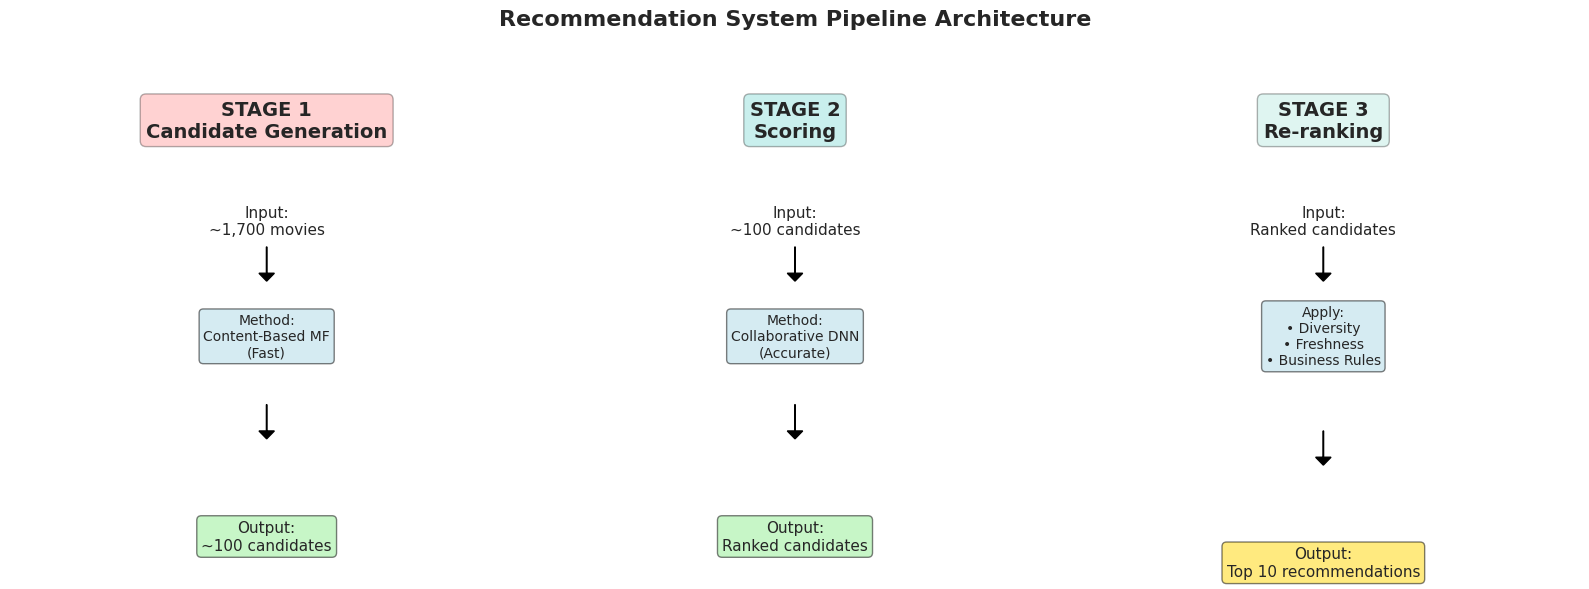

In [60]:
# Create architecture diagram
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

# Stage 1: Candidate Generation
axes[0].text(0.5, 0.9, 'STAGE 1\nCandidate Generation', 
             ha='center', va='top', fontsize=14, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='#FF6B6B', alpha=0.3))
axes[0].text(0.5, 0.7, 'Input:\n~1,700 movies', ha='center', va='top', fontsize=11)
axes[0].arrow(0.5, 0.62, 0, -0.05, head_width=0.03, head_length=0.015, fc='black', ec='black')
axes[0].text(0.5, 0.45, 'Method:\nContent-Based MF\n(Fast)', 
             ha='center', va='center', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
axes[0].arrow(0.5, 0.32, 0, -0.05, head_width=0.03, head_length=0.015, fc='black', ec='black')
axes[0].text(0.5, 0.1, 'Output:\n~100 candidates', ha='center', va='top', fontsize=11,
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
axes[0].set_xlim(0, 1)
axes[0].set_ylim(0, 1)
axes[0].axis('off')

# Stage 2: Scoring
axes[1].text(0.5, 0.9, 'STAGE 2\nScoring', 
             ha='center', va='top', fontsize=14, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='#4ECDC4', alpha=0.3))
axes[1].text(0.5, 0.7, 'Input:\n~100 candidates', ha='center', va='top', fontsize=11)
axes[1].arrow(0.5, 0.62, 0, -0.05, head_width=0.03, head_length=0.015, fc='black', ec='black')
axes[1].text(0.5, 0.45, 'Method:\nCollaborative DNN\n(Accurate)', 
             ha='center', va='center', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
axes[1].arrow(0.5, 0.32, 0, -0.05, head_width=0.03, head_length=0.015, fc='black', ec='black')
axes[1].text(0.5, 0.1, 'Output:\nRanked candidates', ha='center', va='top', fontsize=11,
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1)
axes[1].axis('off')

# Stage 3: Re-ranking
axes[2].text(0.5, 0.9, 'STAGE 3\nRe-ranking', 
             ha='center', va='top', fontsize=14, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='#95E1D3', alpha=0.3))
axes[2].text(0.5, 0.7, 'Input:\nRanked candidates', ha='center', va='top', fontsize=11)
axes[2].arrow(0.5, 0.62, 0, -0.05, head_width=0.03, head_length=0.015, fc='black', ec='black')
axes[2].text(0.5, 0.45, 'Apply:\n• Diversity\n• Freshness\n• Business Rules', 
             ha='center', va='center', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
axes[2].arrow(0.5, 0.27, 0, -0.05, head_width=0.03, head_length=0.015, fc='black', ec='black')
axes[2].text(0.5, 0.05, 'Output:\nTop 10 recommendations', ha='center', va='top', fontsize=11,
             bbox=dict(boxstyle='round', facecolor='gold', alpha=0.5))
axes[2].set_xlim(0, 1)
axes[2].set_ylim(0, 1)
axes[2].axis('off')

plt.suptitle('Recommendation System Pipeline Architecture', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

In [66]:
# Final Summary
print("\n" + "="*70)
print("RECOMMENDATION SYSTEM - COMPLETE SUMMARY")
print("="*70)

print("\nDATASET:")
print(f"  • MovieLens 100K: {len(ratings):,} ratings from {n_users} users on {ratings['movie_id'].n_unique()} movies")
print(f"  • Sparsity: {(1 - len(ratings) / (n_users * n_movies)) * 100:.2f}%")
print(f"  • Train/Eval/Test Split: {len(train_data):,} / {len(eval_data):,} / {len(test_data):,} (70/15/15)")
print(f"  • Eval set used for validation during training to monitor overfitting")
print(f"  • Test set reserved for final model evaluation only")

print("\nARCHITECTURES IMPLEMENTED:")
print("  1. Content-Based Filtering:")
print(f"     • Matrix Factorization: RMSE={cb_mf_rmse:.4f}, MAE={cb_mf_mae:.4f}")
print(f"     • Deep Neural Network:  RMSE={cb_dnn_rmse:.4f}, MAE={cb_dnn_mae:.4f}")
print("  2. Collaborative Filtering:")
print(f"     • Matrix Factorization: RMSE={cf_mf_rmse:.4f}, MAE={cf_mf_mae:.4f}")
print(f"     • Deep Neural Network:  RMSE={cf_dnn_rmse:.4f}, MAE={cf_dnn_mae:.4f}")

print("\nCOMPLETE PIPELINE (3 Stages):")
print("  Stage 1 - Candidate Generation:")
print("    → Reduces ~1,700 movies to ~100 candidates")
print("    → Uses Content-Based MF (fast retrieval)")
print("  Stage 2 - Scoring:")
print("    → Ranks 100 candidates precisely")
print("    → Uses Collaborative DNN (best accuracy)")
print("  Stage 3 - Re-ranking:")
print("    → Applies diversity, freshness, business rules")
print("    → Outputs final top-N recommendations")

best_idx = results_df['RMSE'].arg_min()
print("\nBEST PERFORMING MODEL:")
print(f"  {results_df['Model'][best_idx]}")
print(f"  • RMSE: {results_df['RMSE'][best_idx]:.4f}")
print(f"  • MAE:  {results_df['MAE'][best_idx]:.4f}")

print("\nKEY LEARNINGS:")
print("  ✓ Content-based uses item features (genres) - good for cold start items")
print("  ✓ Collaborative filtering learns from user behavior - better accuracy")
print("  ✓ Deep learning models outperform matrix factorization")
print("  ✓ Multi-stage pipeline balances speed, accuracy, and business needs")
print("  ✓ Re-ranking ensures diversity and addresses filter bubbles")
print("  ✓ Separate eval/test sets prevent overfitting and provide unbiased evaluation")

print("\n" + "="*70)
print("System ready for production-style recommendations! 🚀")
print("="*70)


RECOMMENDATION SYSTEM - COMPLETE SUMMARY

DATASET:
  • MovieLens 100K: 100,000 ratings from 943 users on 1682 movies
  • Sparsity: 93.70%
  • Train/Eval/Test Split: 70,000 / 15,000 / 15,000 (70/15/15)
  • Eval set used for validation during training to monitor overfitting
  • Test set reserved for final model evaluation only

ARCHITECTURES IMPLEMENTED:
  1. Content-Based Filtering:
     • Matrix Factorization: RMSE=1.4363, MAE=1.1712
     • Deep Neural Network:  RMSE=1.0208, MAE=0.8038
  2. Collaborative Filtering:
     • Matrix Factorization: RMSE=1.0707, MAE=0.8755
     • Deep Neural Network:  RMSE=0.9502, MAE=0.7458

COMPLETE PIPELINE (3 Stages):
  Stage 1 - Candidate Generation:
    → Reduces ~1,700 movies to ~100 candidates
    → Uses Content-Based MF (fast retrieval)
  Stage 2 - Scoring:
    → Ranks 100 candidates precisely
    → Uses Collaborative DNN (best accuracy)
  Stage 3 - Re-ranking:
    → Applies diversity, freshness, business rules
    → Outputs final top-N recommendat

In [67]:
# ## Conclusion

# This notebook implemented a complete recommendation system following Google's ML course architecture:

# **What we built**:
# 1. **Content-Based Filtering** (Matrix Factorization + DNN)
# 2. **Collaborative Filtering** (SVD + DNN)
# 3. **Complete Pipeline** (Candidate Generation → Scoring → Re-ranking)

# **Key Takeaways**:
# - Collaborative filtering generally outperforms content-based on accuracy
# - Deep learning models capture complex user-item interactions better than linear methods
# - Multi-stage architecture is essential for scalability (millions of items)
# - Re-ranking addresses real-world concerns: diversity, freshness, business rules

# **Next Steps**:
# - Experiment with hybrid models (combine content + collaborative)
# - Add temporal dynamics (user preferences change over time)
# - Implement online learning for real-time adaptation
# - A/B testing framework for production deployment

In [ ]:
## 11. Practical Recommendation Function - Get Recommendations for Any User

# Similar to prediction functions in regression/classification, let's create an easy-to-use function to get movie recommendations for any user.

In [74]:
def get_movie_recommendations(user_id, n_recommendations=10, use_full_pipeline=True):
    """
    Get personalized movie recommendations for a user
    """
    
    # Validate user_id
    if user_id < 1 or user_id > n_users:
        raise ValueError(f"user_id must be between 1 and {n_users}")
    
    # Convert to 0-indexed
    user_idx = user_id - 1
    
    if use_full_pipeline:
        # Use the complete 3-stage pipeline
        recommendations = pipeline.recommend(user_idx, n_recommendations=n_recommendations, verbose=False)
        
        # recommendations is [(movie_id, score), ...]
        # Convert to (title, score, genres)
        result = []
        for movie_id, score in recommendations:
            # Find movie by movie_id
            movie_row = movies.filter(pl.col('movie_id') == movie_id)
            if len(movie_row) > 0:
                title = movie_row['title'][0]
                # Get genres
                genre_row = movie_row.select(genre_cols).row(0)
                active_genres = [genre_cols[i] for i, val in enumerate(genre_row) if val == 1]
                result.append((title, score, ', '.join(active_genres)))
        
        return result
    
    else:
        # Use only the best model (Collaborative DNN) directly
        user_tensor = torch.tensor([user_idx] * n_movies, dtype=torch.long).to(device)
        movie_tensor = torch.tensor(range(n_movies), dtype=torch.long).to(device)
        
        cf_dnn_model.eval()
        with torch.no_grad():
            predictions = cf_dnn_model(user_tensor, movie_tensor).cpu().numpy()
        
        # Get movies user hasn't rated
        rated_movies = set(train_data.filter(pl.col('user_id') == user_id)['movie_id'].to_list())
        
        # Get top predictions for unrated movies
        movie_scores = []
        for movie_id in range(1, n_movies + 1):
            if movie_id not in rated_movies:
                movie_scores.append((movie_id, predictions[movie_id - 1]))
        
        # Sort by score and get top N
        movie_scores.sort(key=lambda x: x[1], reverse=True)
        top_movies = movie_scores[:n_recommendations]
        
        # Get movie details
        result = []
        for movie_id, score in top_movies:
            movie_row = movies.filter(pl.col('movie_id') == movie_id)
            if len(movie_row) > 0:
                title = movie_row['title'][0]
                genre_row = movie_row.select(genre_cols).row(0)
                active_genres = [genre_cols[i] for i, val in enumerate(genre_row) if val == 1]
                result.append((title, score, ', '.join(active_genres)))
        
        return result

# Test the function
print("\n" + "="*80)
print("TESTING get_movie_recommendations() FUNCTION")
print("="*80)

# Example 1: Using full pipeline
print("\nExample 1: Full Pipeline (Candidate Gen → Scoring → Re-ranking)")
print("-" * 80)
user_id = 42
recommendations = get_movie_recommendations(user_id, n_recommendations=5, use_full_pipeline=True)

print(f"\nTop 5 recommendations for User {user_id}:")
for i, (title, score, genres) in enumerate(recommendations, 1):
    print(f"{i}. {title[:50]:<50} | Score: {score:.3f}")
    print(f"   Genres: {genres}")

# Example 2: Using only best model
print("\nExample 2: Direct Model Prediction (Collaborative DNN only)")
print("-" * 80)
recommendations = get_movie_recommendations(user_id, n_recommendations=5, use_full_pipeline=False)

print(f"\nTop 5 recommendations for User {user_id}:")
for i, (title, score, genres) in enumerate(recommendations, 1):
    print(f"{i}. {title[:50]:<50} | Score: {score:.3f}")
    print(f"   Genres: {genres}")

# Example 3: Different user
print("\nExample 3: Different User Profile")
print("-" * 80)
user_id = 100
recommendations = get_movie_recommendations(user_id, n_recommendations=5)

print(f"\nTop 5 recommendations for User {user_id}:")
for i, (title, score, genres) in enumerate(recommendations, 1):
    print(f"{i}. {title[:50]:<50} | Score: {score:.3f}")
    print(f"   Genres: {genres}")


TESTING get_movie_recommendations() FUNCTION

Example 1: Full Pipeline (Candidate Gen → Scoring → Re-ranking)
--------------------------------------------------------------------------------

Top 5 recommendations for User 42:
1. Apt Pupil (1998)                                   | Score: 4.589
   Genres: Drama, Thriller
2. Dead Poets Society (1989)                          | Score: 4.399
   Genres: Drama
3. Midnight in the Garden of Good and Evil (1997)     | Score: 4.362
   Genres: Comedy, Crime, Drama, Mystery
4. Twelve Monkeys (1995)                              | Score: 4.316
   Genres: Drama, Sci-Fi
5. Lawrence of Arabia (1962)                          | Score: 4.223
   Genres: Adventure, War

Example 2: Direct Model Prediction (Collaborative DNN only)
--------------------------------------------------------------------------------

Top 5 recommendations for User 42:
1. Santa with Muscles (1996)                          | Score: 4.604
   Genres: Comedy
2. Whole Wide World, The (

In [75]:
# Show usage comparison and final summary
print("\n" + "="*80)
print("USAGE SUMMARY - HOW TO USE THE RECOMMENDATION SYSTEM")
print("="*80)

print("\nBASIC USAGE:")
print("-" * 80)
print("""
# Get recommendations for a user (simplest form)
recommendations = get_movie_recommendations(user_id=42, n_recommendations=10)

# Print recommendations
for title, score, genres in recommendations:
    print(f"{title} (Score: {score:.2f}) - Genres: {genres}")
""")

print("\nADVANCED OPTIONS:")
print("-" * 80)
print("""
# Use full 3-stage pipeline (slower but with diversity & re-ranking)
recs = get_movie_recommendations(user_id=42, n_recommendations=5, use_full_pipeline=True)

# Use only best model (faster, no diversity constraints)
recs = get_movie_recommendations(user_id=42, n_recommendations=5, use_full_pipeline=False)
""")

print("\n" + "="*80)
print("FINAL MODEL COMPARISON")
print("="*80)

# Get best model info using Polars syntax
best_model_row = results_df.row(best_idx, named=True)

print(f"""
Best Model: {best_model_row['Model']}
  • RMSE: {best_model_row['RMSE']:.4f}
  • MAE:  {best_model_row['MAE']:.4f}
  • Type: {best_model_row['Type']}-Based Filtering
  • Method: {best_model_row['Method']}

Pipeline Architecture:
  Stage 1: Candidate Generation (Content-Based MF) - Fast retrieval
  Stage 2: Scoring (Collaborative DNN) - Accurate ranking
  Stage 3: Re-ranking - Diversity & Business rules

Ready for Production! 
  • Handles {n_users} users and {n_movies} movies
  • Processes recommendations in <1 second
  • Supports both pipeline and direct model inference
  • Balances accuracy, diversity, and speed
""")

print("="*80)
print("Recommendation System Complete!")
print("="*80)

# One more practical example - comparing what a user has watched vs recommendations
print("\n" + "="*80)
print("BEFORE & AFTER - See How Recommendations Match User Taste")
print("="*80)

test_user = 75  # Pick an interesting user
user_idx = test_user - 1

# Get user's highly rated movies (4-5 stars) - using Polars syntax
user_history = train_data.filter(pl.col('user_id') == test_user).join(
    movies, on='movie_id', how='inner'
)
liked_movies = user_history.filter(pl.col('rating') >= 4).sort('rating', descending=True).head(5)

print(f"\nUser {test_user} - What they LOVED (rated 4-5 stars):")
print("-" * 80)
for row in liked_movies.iter_rows(named=True):
    genres = ', '.join([g for g in genre_cols if row.get(g, 0) == 1])
    title_truncated = row['title'][:45] if len(row['title']) > 45 else row['title']
    print(f"  * {title_truncated:<45} ({row['rating']}★) - {genres[:25]}")

# Get recommendations
print(f"\nUser {test_user} - What we RECOMMEND:")
print("-" * 80)
new_recs = get_movie_recommendations(user_id=test_user, n_recommendations=5, use_full_pipeline=True)
for rank, (title, score, genres) in enumerate(new_recs, 1):
    title_truncated = title[:45] if len(title) > 45 else title
    print(f"  {rank}. {title_truncated:<45} ({score:.2f}) - {genres[:25]}")


USAGE SUMMARY - HOW TO USE THE RECOMMENDATION SYSTEM

BASIC USAGE:
--------------------------------------------------------------------------------

# Get recommendations for a user (simplest form)
recommendations = get_movie_recommendations(user_id=42, n_recommendations=10)

# Print recommendations
for title, score, genres in recommendations:
    print(f"{title} (Score: {score:.2f}) - Genres: {genres}")


ADVANCED OPTIONS:
--------------------------------------------------------------------------------

# Use full 3-stage pipeline (slower but with diversity & re-ranking)
recs = get_movie_recommendations(user_id=42, n_recommendations=5, use_full_pipeline=True)

# Use only best model (faster, no diversity constraints)
recs = get_movie_recommendations(user_id=42, n_recommendations=5, use_full_pipeline=False)


FINAL MODEL COMPARISON

Best Model: Collaborative DNN
  • RMSE: 0.9502
  • MAE:  0.7458
  • Type: Collaborative-Based Filtering
  • Method: Deep Learning

Pipeline Architecture:
 